In [1]:
!kaggle competitions download -c cassava-leaf-disease-classification

100%|█████████████████████████████████████▉| 5.76G/5.76G [25:36<00:00, 4.29MB/s]
100%|██████████████████████████████████████| 5.76G/5.76G [25:36<00:00, 4.03MB/s]


In [1]:
!unzip -q cassava-leaf-disease-classification.zip -d cassava-leaf-disease-classification

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.callbacks as callbacks
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.preprocessing as preprocessing
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import albumentations as A
from sklearn.model_selection import KFold


gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
logical = tf.config.list_logical_devices('GPU')
print(len(gpus), 'Physical GPUs', len(logical), 'Logical GPUs')

tf.random.set_seed(666)

1 Physical GPUs 1 Logical GPUs


In [2]:
samples_df = pd.read_csv('./cassava-leaf-disease-classification/train.csv')
samples_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [3]:
TRAIN_FOLDER = './cassava-leaf-disease-classification/train_images/'
samples_df['filepath'] = TRAIN_FOLDER + samples_df['image_id']
samples_df['label_col'] = samples_df['label'].astype(str)
samples_df.head()

,image_id,label,filepath,label_col
0,1000015157.jpg,0,./cassava-leaf-disease-classification/train_im...,0
1,1000201771.jpg,3,./cassava-leaf-disease-classification/train_im...,3
2,100042118.jpg,1,./cassava-leaf-disease-classification/train_im...,1
3,1000723321.jpg,1,./cassava-leaf-disease-classification/train_im...,1
4,1000812911.jpg,3,./cassava-leaf-disease-classification/train_im...,3


In [4]:
CLASSES = sorted(samples_df.label_col.unique())
print(CLASSES)

['0', '1', '2', '3', '4']


In [5]:
skf = KFold(n_splits=5)

for train_index, test_index in skf.split(samples_df):
  print("TRAIN:", train_index, "TEST:", test_index)
  training_df = samples_df.iloc[train_index]
  validation_df = samples_df.iloc[test_index]

TRAIN: [ 4280  4281  4282 ... 21394 21395 21396] TEST: [   0    1    2 ... 4277 4278 4279]
TRAIN: [    0     1     2 ... 21394 21395 21396] TEST: [4280 4281 4282 ... 8557 8558 8559]
TRAIN: [    0     1     2 ... 21394 21395 21396] TEST: [ 8560  8561  8562 ... 12836 12837 12838]
TRAIN: [    0     1     2 ... 21394 21395 21396] TEST: [12839 12840 12841 ... 17115 17116 17117]
TRAIN: [    0     1     2 ... 17115 17116 17117] TEST: [17118 17119 17120 ... 21394 21395 21396]


Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.
classes:  {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}


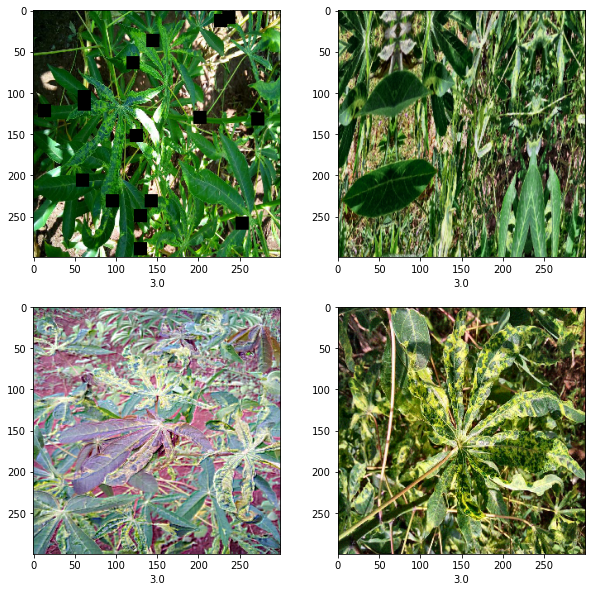

In [6]:
ImageDataGenerator = preprocessing.image.ImageDataGenerator

def augmentation(image):
  transform = A.Compose([
    A.RandomRotate90(),
    A.Flip(),
    A.Transpose(),
    A.OneOf([A.IAAAdditiveGaussianNoise(), A.GaussNoise()], p=0.2),
    A.OneOf([
      A.MotionBlur(p=.2),
      A.MedianBlur(blur_limit=3, p=0.1),
      A.Blur(blur_limit=3, p=0.1)],
    p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
    A.OneOf([
      A.OpticalDistortion(p=0.3),
      A.GridDistortion(p=.1),
      A.IAAPiecewiseAffine(p=0.3)],
    p=0.2),
    A.OneOf([
      A.CLAHE(clip_limit=2),
      A.IAASharpen(),
      A.IAAEmboss(),
      A.RandomBrightnessContrast(),
      A.HueSaturationValue(hue_shift_limit=30),
      A.RandomFog(p=.3)
    ], p=0.7),
    A.HueSaturationValue(p=0.3),
    A.OneOf([
      A.CoarseDropout(max_holes=16, max_height=16, max_width=16),
      A.Cutout(num_holes=16, max_h_size=16, max_w_size=16),
      A.ElasticTransform(alpha=1, sigma=25)
    ], p=0.4)
  ])
  return transform(image=image.astype(np.uint8))['image']


BATCH_SIZE = 16
IMAGE_SIZE = 300

def create_generators(training_df, validation_df):
  training_generator = ImageDataGenerator(preprocessing_function=augmentation)
  validation_generator = ImageDataGenerator()


  training_dg = training_generator.flow_from_dataframe(training_df,
                                                       x_col='filepath', y_col='label_col',
                                                       target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                       batch_size=BATCH_SIZE, shuffle=True,
                                                       class_mode='sparse')

  validation_dg = validation_generator.flow_from_dataframe(validation_df,
                                                           x_col='filepath', y_col='label_col',
                                                           target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                           batch_size=BATCH_SIZE,
                                                           class_mode='sparse')
  return training_dg, validation_dg



training_dg, validation_dg = create_generators(training_df, validation_df)
print('classes: ', training_dg.class_indices)
print(validation_dg.class_indices)

plt.figure(figsize=(10, 10))
for batch in training_dg:
  images, labels = batch
  for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i, ...].astype(np.uint8))
    plt.xlabel(str(labels[i]))
  plt.show()
  break

In [7]:
def build_model():
  model = keras.Sequential([
    keras.applications.EfficientNetB3(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                                      weights='imagenet',
                                      include_top=False,
                                      pooling='avg',
                                      drop_connect_rate=0.6),
    layers.Dropout(0.5),
    layers.Dense(256),
    layers.Dropout(0.3),
    layers.Activation('relu'),
    layers.Dense(len(CLASSES), activation="softmax"),
  ])
  model.compile(optimizer=optimizers.Adam(1e-4),
                loss='sparse_categorical_crossentropy',
                metrics=["accuracy"])
  return model


keras.backend.clear_session()
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               393472    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 11,178,292
Trainable params: 11,090,989
Non-trainable params: 87,303
_______________________________________

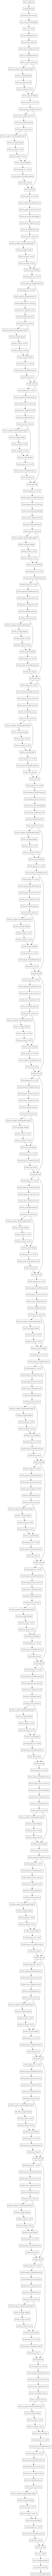

In [8]:
from tensorflow.keras.utils import plot_model
plot_model(model.get_layer('efficientnetb3'), to_file='conv_base.png')

In [9]:
def process_image_data(image_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = model.get_layer('efficientnetb3').get_layer('rescaling')(image)
  return image

AUTOTUNE = tf.data.experimental.AUTOTUNE
image_data = tf.data.Dataset.from_tensor_slices((samples_df.filepath.values))
image_data = image_data.map(process_image_data, num_parallel_calls=AUTOTUNE)
image_data = image_data.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
model.get_layer('efficientnetb3').get_layer('normalization').adapt(image_data)

In [10]:
model.save_weights('leaf_init_weights.h5')

In [13]:
EPOCHS = 30


def schedule(epoch, lr):
  if epoch == 0:
    return 1e-4
  if epoch in [10]:
    return lr / 10.0
  return lr


history = []
fold = 0
for train_index, test_index in skf.split(samples_df):
  if fold == 0:
    fold += 1
    continue
  training_df = samples_df.iloc[train_index]
  validation_df = samples_df.iloc[test_index]
  training_dg, validation_dg = create_generators(training_df, validation_df)
  
  model.load_weights('leaf_init_weights.h5')
  save_point = callbacks.ModelCheckpoint(filepath='leaf_best_model_fold_{}.h5'.format(fold),
                                         monitor='val_accuracy',
                                         save_best_only=True, verbose=True)
  scheduler = callbacks.LearningRateScheduler(schedule, verbose=True)


  train_history = model.fit(training_dg,
                            epochs=EPOCHS,
                            validation_data=validation_dg,
                            callbacks=[save_point, scheduler])
  history.append(train_history)
  fold += 1

Found 17117 validated image filenames belonging to 5 classes.
Found 4280 validated image filenames belonging to 5 classes.

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/30
1070/1070 [==============================] - ETA: 0s - loss: 0.8411 - accuracy: 0.6918
Epoch 00001: val_accuracy improved from -inf to 0.82243, saving model to leaf_best_model_fold_1.h5
1070/1070 [==============================] - 389s 364ms/step - loss: 0.8411 - accuracy: 0.6918 - val_loss: 0.5166 - val_accuracy: 0.8224

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 2/30
1070/1070 [==============================] - ETA: 0s - loss: 0.6275 - accuracy: 0.7754
Epoch 00002: val_accuracy improved from 0.82243 to 0.84626, saving model to leaf_best_model_fold_1.h5
1070/1070 [==============================] - 389s 364ms/step - loss: 0.6275 - accuracy: 0.7754 - val_loss: 0.4591 - val_accuracy: 0.8463

Epoch 00003: LearningRateScheduler reducing learni


Epoch 00021: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 21/30
1070/1070 [==============================] - ETA: 0s - loss: 0.3480 - accuracy: 0.8762
Epoch 00021: val_accuracy did not improve from 0.88458
1070/1070 [==============================] - 368s 344ms/step - loss: 0.3480 - accuracy: 0.8762 - val_loss: 0.3735 - val_accuracy: 0.8846

Epoch 00022: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 22/30
1070/1070 [==============================] - ETA: 0s - loss: 0.3493 - accuracy: 0.8763
Epoch 00022: val_accuracy did not improve from 0.88458
1070/1070 [==============================] - 367s 343ms/step - loss: 0.3493 - accuracy: 0.8763 - val_loss: 0.3728 - val_accuracy: 0.8843

Epoch 00023: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 23/30
1070/1070 [==============================] - ETA: 0s - loss: 0.3444 - accuracy: 0.8804
Epoch 00023: val_accuracy improved from 0.88458 to 0.88505, savi

1070/1070 [==============================] - ETA: 0s - loss: 0.4260 - accuracy: 0.8527
Epoch 00010: val_accuracy improved from 0.88268 to 0.88712, saving model to leaf_best_model_fold_2.h5
1070/1070 [==============================] - 382s 357ms/step - loss: 0.4260 - accuracy: 0.8527 - val_loss: 0.3405 - val_accuracy: 0.8871

Epoch 00011: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 11/30
1070/1070 [==============================] - ETA: 0s - loss: 0.3863 - accuracy: 0.8661
Epoch 00011: val_accuracy did not improve from 0.88712
1070/1070 [==============================] - 399s 373ms/step - loss: 0.3863 - accuracy: 0.8661 - val_loss: 0.3355 - val_accuracy: 0.8848

Epoch 00012: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 12/30
1070/1070 [==============================] - ETA: 0s - loss: 0.3794 - accuracy: 0.8673
Epoch 00012: val_accuracy did not improve from 0.88712
1070/1070 [==============================] - 381s 356ms/ste

1070/1070 [==============================] - ETA: 0s - loss: 0.7839 - accuracy: 0.7154
Epoch 00001: val_accuracy improved from -inf to 0.81164, saving model to leaf_best_model_fold_3.h5
1070/1070 [==============================] - 377s 352ms/step - loss: 0.7839 - accuracy: 0.7154 - val_loss: 0.5297 - val_accuracy: 0.8116

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 2/30
1070/1070 [==============================] - ETA: 0s - loss: 0.5986 - accuracy: 0.7870
Epoch 00002: val_accuracy improved from 0.81164 to 0.84716, saving model to leaf_best_model_fold_3.h5
1070/1070 [==============================] - 381s 356ms/step - loss: 0.5986 - accuracy: 0.7870 - val_loss: 0.4417 - val_accuracy: 0.8472

Epoch 00003: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 3/30
1070/1070 [==============================] - ETA: 0s - loss: 0.5431 - accuracy: 0.8111
Epoch 00003: val_accuracy improved from 0.84716 to 0.84810, saving model


Epoch 00022: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 22/30
1070/1070 [==============================] - ETA: 0s - loss: 0.3377 - accuracy: 0.8816
Epoch 00022: val_accuracy did not improve from 0.87380
1070/1070 [==============================] - 369s 344ms/step - loss: 0.3377 - accuracy: 0.8816 - val_loss: 0.3802 - val_accuracy: 0.8729

Epoch 00023: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 23/30
1070/1070 [==============================] - ETA: 0s - loss: 0.3357 - accuracy: 0.8815
Epoch 00023: val_accuracy improved from 0.87380 to 0.87427, saving model to leaf_best_model_fold_3.h5
1070/1070 [==============================] - 368s 344ms/step - loss: 0.3357 - accuracy: 0.8815 - val_loss: 0.3813 - val_accuracy: 0.8743

Epoch 00024: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 24/30
1070/1070 [==============================] - ETA: 0s - loss: 0.3424 - accuracy: 0.8782
Epoch 00024: val_

1070/1070 [==============================] - 373s 348ms/step - loss: 0.3931 - accuracy: 0.8644 - val_loss: 0.3640 - val_accuracy: 0.8752

Epoch 00012: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 12/30
1070/1070 [==============================] - ETA: 0s - loss: 0.3796 - accuracy: 0.8656
Epoch 00012: val_accuracy improved from 0.87520 to 0.87707, saving model to leaf_best_model_fold_4.h5
1070/1070 [==============================] - 372s 348ms/step - loss: 0.3796 - accuracy: 0.8656 - val_loss: 0.3603 - val_accuracy: 0.8771

Epoch 00013: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 13/30
1070/1070 [==============================] - ETA: 0s - loss: 0.3795 - accuracy: 0.8656
Epoch 00013: val_accuracy improved from 0.87707 to 0.87871, saving model to leaf_best_model_fold_4.h5
1070/1070 [==============================] - 372s 348ms/step - loss: 0.3795 - accuracy: 0.8656 - val_loss: 0.3603 - val_accuracy: 0.8787

Epoch 00014: Lea

In [14]:
test_df = pd.read_csv('./cassava-leaf-disease-classification/sample_submission.csv')
test_df.head()

,image_id,label
0,2216849948.jpg,4


In [23]:
from tqdm import tqdm
from PIL import Image

TEST_FOLDER = 'cassava-leaf-disease-classification/test_images'

def predict_test():
  prediction = []
  for i in range(5):
    print('loading weights...')
    model.load_weights('leaf_best_model_fold_{}.h5'.format(i))
    p = []
    for i in tqdm(range(len(test_df.values))):
      row = test_df.values[i]
      img_path = os.path.join(TEST_FOLDER, row[0])
      image = Image.open(img_path).resize((IMAGE_SIZE, IMAGE_SIZE))
      image = np.array(image).reshape([-1, IMAGE_SIZE, IMAGE_SIZE, 3])
      ans = model.predict(image.astype(np.float32))
      p.append(ans[0])
    prediction.append(p)
  prediction = np.average(prediction, axis=0)
  prediction = np.argmax(prediction, axis=1)
  return prediction


model.load_weights('./leaf_best_model.h5')
test_df['label'] = predict_test()

  0%|          | 0/1 [00:00<?, ?it/s]

loading weights...


  0%|          | 0/1 [00:00<?, ?it/s]

loading weights...


100%|██████████| 1/1 [00:00<00:00, 24.42it/s]


loading weights...
loading weights...


100%|██████████| 1/1 [00:00<00:00, 25.48it/s]

loading weights...


In [24]:
test_df.to_csv("submission.csv", index=False)

In [25]:
test_df

,image_id,label
0,2216849948.jpg,4
